# Numerai Example Notebook

Welcome to the [Numerai](https://numer.ai/) data science tournament! If you are just getting started, this notebook is for you.

In this notebook we will go through
1. Dataset: how to download it and its basic structure
2. Modelling: how to train our first model and evaluate its performance  
3. Submissions: how to upload our first model to start competing in the tournament 

In [1]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

## 1. Dataset  

Let's download the dataset and get familar with its basic structure. 


In [2]:
from numerapi import NumerAPI
from scipy import stats
import pandas as pd
import numpy as np
import json

In [3]:
# Numerai API is the official Python API client for Numerai
# We will be using it to download the data from the Numerai API
napi = NumerAPI()

In [4]:
# v4.1 is the latest version of the dataset
# Let's see what files are available for download
[f for f in napi.list_datasets() if f.startswith("v4.1")]

['v4.1/features.json',
 'v4.1/live.parquet',
 'v4.1/live_example_preds.csv',
 'v4.1/live_example_preds.parquet',
 'v4.1/live_int8.parquet',
 'v4.1/meta_model.parquet',
 'v4.1/train.parquet',
 'v4.1/train_int8.parquet',
 'v4.1/validation.parquet',
 'v4.1/validation_example_preds.csv',
 'v4.1/validation_example_preds.parquet',
 'v4.1/validation_int8.parquet']

In this example, we will focus on the following files:
- `features.json`: feature metadata 
- `train.parquet`: historical training data for training our model
- `validation.parquet`: historical validation data for evaluating our model performance
- `live.parquet`: live features for making submissions

In [5]:
# Let's download the training data and feature metadata files
# This will take about 1 minute 🍵
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

2023-04-12 15:50:03,561 INFO numerapi.utils: starting download
v4.1/train.parquet: 1.45GB [01:20, 17.9MB/s]                            
2023-04-12 15:51:24,677 INFO numerapi.utils: starting download
v4.1/features.json: 703kB [00:00, 3.56MB/s]                           


In [6]:
# The feature metadata file contains a lot of useful information about the features
# In particular, it defines various feature sets that are useful for training and evaluating models
feature_metadata = json.load(open("v4.1/features.json")) 
feature_metadata["feature_sets"].keys()

dict_keys(['small', 'medium', 'v2_equivalent_features', 'v3_equivalent_features', 'fncv3_features'])

In [7]:
# In this example, we will be using the "small" feature set to minimize the memory footprint and training time of our model 
# In practice you will probably want to use all the features to maximize your model's performance
feature_cols = feature_metadata["feature_sets"]["small"]

# Here we will only load the "small" subset of feature columns that we need
# Using the "columns" argument when loading parquet files will save us a lot of memory and time
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + ["target"]) 

In [8]:
# Let's take a look at the training data
# We limit the number of rows and columns displayed to make it easier to read
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
training_data

,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n003bba8a98662e4,0001,0.00,...,0.00,0.25
n003bee128c2fcfc,0001,0.50,...,0.25,0.75
n0048ac83aff7194,0001,0.25,...,1.00,0.50
n00691bec80d3e02,0001,0.75,...,0.75,0.75
n00b8720a2fdc4f2,0001,0.00,...,0.00,0.75
...,...,...,...,...,...
nffcc1dbdf2212e6,0574,1.00,...,1.00,0.75
nffd71b7f6a128df,0574,0.75,...,0.50,0.00
nffde3b371d67394,0574,0.75,...,1.00,0.25


The Numerai dataset is about the stock market. Each row represents a stock at a specific point in time
- The `era` represents that point in time
- The `features` are quantiative measures of the stock known at the point in time
- The `target` represents the 20 day subsequent return from the point in time

This stock ids, dates, and feature names in this dataset are <ins>obfuscated</ins>. For example
- id `n003bba8a98662e4` in era `0001` could be "TSLA on Jan 31st 2019"
- feature `feature_bijou_penetrant_syringa=0.00` could mean "P/E ratio in the bottom 20th percentile within the technology sector"
- `target=0.25` could mean "20 day subsequent reteruns in the bottom 40th percentile across the entire market" 

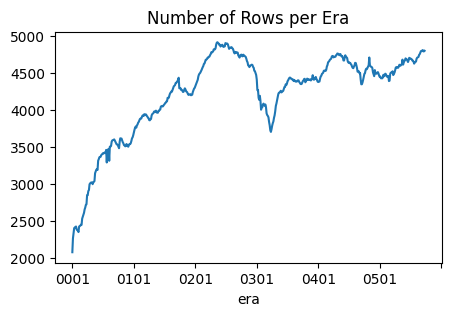

In [9]:
# Let's plot the number of rows per era
# This correspondss to the number stocks in Numerai's investable universe over time
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3));

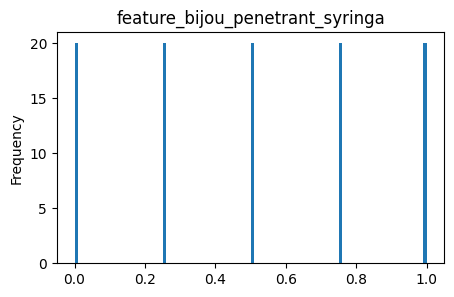

In [10]:
# Feature values are all between 0 and 1 and binned into 5 equal bins 
training_data[feature_cols[0]].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title=feature_cols[0]);

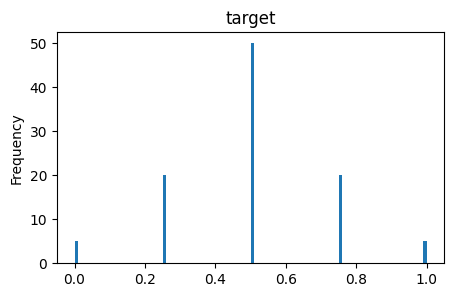

In [11]:
# The target value is also between 0 and 1 but binned into 5 unequal bins
training_data["target"].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title="target");

## 2. Modelling
Our task is to train a machine learning model to predict the target. 

Below we will train an example model and go through some of the key metrics used to evaluate model performance. 

In [12]:
# Let's train a simple model using LightGBM
# This will take about 2 minutes 🍵
from lightgbm import LGBMRegressor
params = {
   "n_estimators": 2000,
   "learning_rate": 0.01,
   "max_depth": 5,
   "num_leaves": 2 ** 5,
   "colsample_bytree": 0.1
}
model = LGBMRegressor(**params)
model.fit(
   training_data[feature_cols],
   training_data["target"]
);

In [13]:
# Let's download the validation dataset and make predictions against it to evaluate our model
# This will take about 2 minutes 🍵
napi.download_dataset("v4.1/validation.parquet");

2023-04-12 15:53:51,281 INFO numerapi.utils: starting download
v4.1/validation.parquet: 1.54GB [01:19, 19.3MB/s]                            


In [14]:
# Again we only load the "small" subset of the features to save time and memory
# This time, we will also load the "data_type" column so that we can filter against it
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"])

# In this example we will only need the rows where data_type == "validation"
# We can drop the "data_type" column after filtering as we no longer need it
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]


In [15]:
# The structure of the validation dataset is the same as the training dataset
# Notice the eras pick up where the training dataset eras left off
validation_data

,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n000101811a8a843,0575,0.25,...,0.75,0.50
n001e1318d5072ac,0575,0.50,...,0.75,0.00
n002a9c5ab785cbb,0575,0.25,...,0.25,0.50
n002ccf6d0e8c5ad,0575,0.25,...,0.00,0.25
n0051ab821295c29,0575,1.00,...,1.00,0.50
...,...,...,...,...,...
nffd4dca666527aa,1052,0.50,...,0.75,0.50
nffdbcade5a291a7,1052,0.75,...,0.25,0.50
nfff85c23d664eed,1052,0.50,...,1.00,1.00


In [16]:
# Let's make predictions against the validation dataset
# This will take about 2 minutes 🍵
predictions = pd.Series(model.predict(validation_data[feature_cols]), index=validation_data.index)

In [17]:
# Let's take a look at our predictions lined up with the target values
validation_data["prediction"] = predictions
validation_data[["era", "prediction", "target"]]

,era,prediction,target
id,,,
n000101811a8a843,0575,0.483958,0.50
n001e1318d5072ac,0575,0.494990,0.00
n002a9c5ab785cbb,0575,0.501213,0.50
n002ccf6d0e8c5ad,0575,0.507834,0.25
n0051ab821295c29,0575,0.484320,0.50
...,...,...,...
nffd4dca666527aa,1052,0.487333,0.50
nffdbcade5a291a7,1052,0.503214,0.50
nfff85c23d664eed,1052,0.487037,1.00


Numerai uses a special correlation metric to evaluate the performance of models. 

At a high level, this metric is designed to be a good proxy for actual portfolio returns if the predictions were used in live trading.
- First the predictions are <ins>gauss ranked</ins>. We do this to match our live trading process, where all model predictions are standardized this way before being ensembled together in the meta model.
- Then both the predictions and targets are <ins>raised to the power of 1.5</ins> before calculating the Pearson correlation. We do this to accentuate the tails as the hedge fund tends to only trade the stocks with highest or lowest predicted returns.

The key takeaway here is that your prediction's distribution does not matter. You are only evaluated on your prediction's ranks. And your score depends more on the tails than a typical rank-correlation.

In [18]:
# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then gaussianize predictions to standadize prediction distributions 
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5 
    target_p15 = np.sign(target) * np.abs(target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

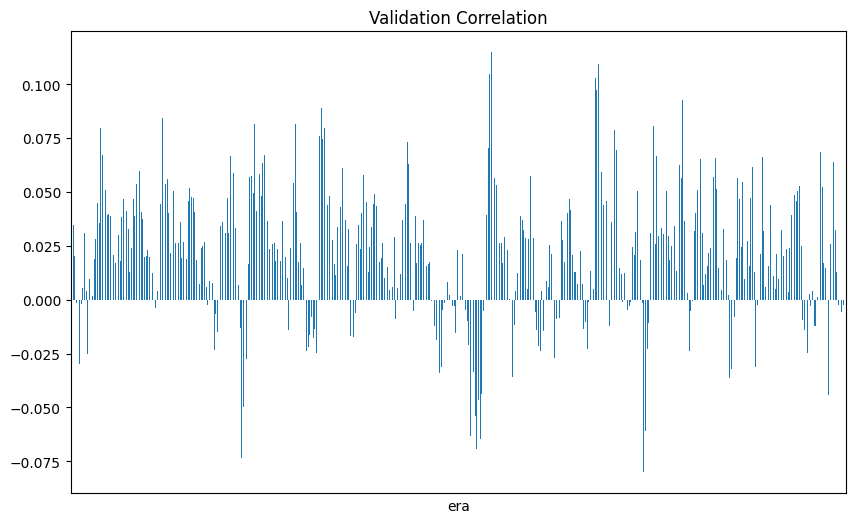

In [19]:
# Compute the per-era correlation between our predictions and the target values
per_era_validation_correlation = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))

# Plot the per-era correlation
per_era_validation_correlation.plot(kind="bar", title="Validation Correlation", figsize=(10, 6), xticks=[]);

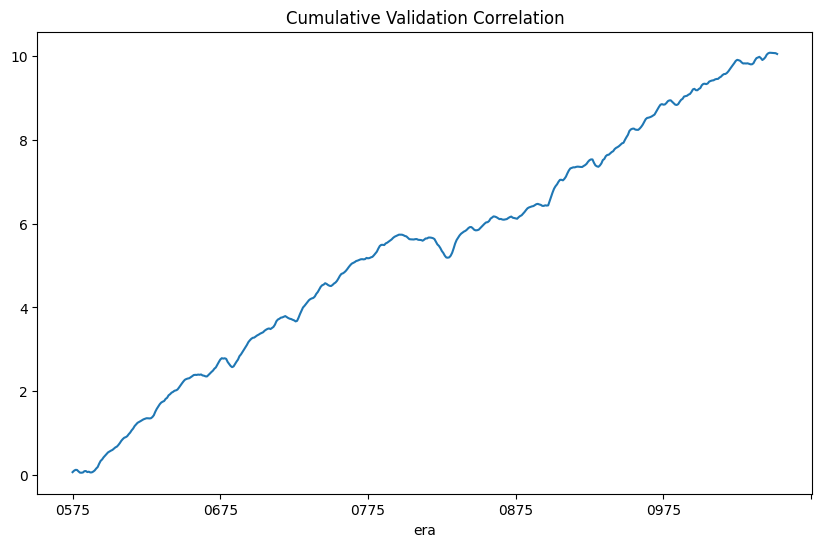

In [20]:
# Another way to visualize our model performance is to look at the cumulative correlation over time
# If you have ever seen a backtest of a trading strategy, this is similar to looking at the cumulative returns over time
cumulative_per_era_validation_correlation = per_era_validation_correlation.cumsum()
cumulative_per_era_validation_correlation.plot(title="Cumulative Validation Correlation", figsize=(10, 6));

In [21]:
# What is the average correlation across all eras?
# You should aim for a correlation mean of at least 0.03 to be considered a good model
correlation_mean = per_era_validation_correlation.mean()
correlation_mean

0.02102306451392744

Apart from correlation, there are a few other important metrics that can be helpful in understanding a model's performance
- `Numerai Sharpe`: a measure of a model's consistency
- `Numerai Max Drawdown`: a measure of a model's worst period of performance 
- `Feature Exposure`: a measure of a model's linear correlation to any single features 
- `Feature Nuetral Correlation`: a measure of a model's performance that is orthogonal to features 

In [22]:
# Sharp ratio is a common metric in finance used to measure the consistency or risk-adjusted performance of an investment strategy
# Typically, the Sharpe ratio is computed as the average return minus the risk free rate divided by the standard deviation of the return
# The higher the return per unit of risk (standard deviation), the better and more consistent the investment strategy
# In Numerai, we compute the Sharpe ratio as the average correlation divided by the standard deviation of the correlation
# You should aim for a Numerai Sharpe ratio of at least 1.0 to be considered a consistent model
correlation_std = per_era_validation_correlation.std(ddof=0)
numerai_sharpe = correlation_mean / correlation_std
numerai_sharpe

0.687923334747409

In [23]:
# Max drawdown is a common metric in finance used to measure the worst case scenario of an investment strategy
# Typically, the max drawdown is computed as the difference between the highest peak and lowest trough of the cumulative returns
# In Numerai, we compute the max drawdown as the difference between the highest peak and lowest trough of the cumulative correlation
# You should aim to minimize the max drawdown of your model but how much you care about this versus maximizing the correlation mean is up to you
rolling_max = cumulative_per_era_validation_correlation.expanding(min_periods=1).max()
max_drawdown = -(rolling_max - cumulative_per_era_validation_correlation).max()
max_drawdown

-0.5500010601490315

In [24]:
# Feature exposure is a metric used to measure the amount and type of risk your model is taking
# Having high expoosure to a single feature means having high linear correlation with that feature
# Models with high exposure to a single feature are considered risky because features are not consistently predictive on their own
# You should aim to minimize feature exposure but how much you care about this versus maximizing the correlation mean is up to you
feature_cols = [f for f in validation_data.columns if f.startswith("feature")]
max_per_era = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["prediction"]).abs().max())
max_feature_exposure = max_per_era.mean()


In [25]:
# Neutralizing predictions against features is the same as removing the linear exposure to features
# In other words, we are computing orthogonal component of the predictions with regards to the feature matrix
# Proportion controls how much of the exposure to neutralize, where 1.0 means 100% of the exposure is neutralized
def neutralize(predictions, features, proportion=1.0):
    # given predictions p and feature matrix F, the orthogonal component p' with regards to F is:
    # p' = p - (F dot (F_inverse dot p))
    inverse_features = np.linalg.pinv(features.values, rcond=1e-6)
    exposure = proportion * features.values.dot(inverse_features.dot(predictions))
    return predictions - exposure

# Feature neutral correlation is just the correlation between the predictions and the target after neutralizing the predictions against the features
# Instead of optimizing for correlation, you may want to optimize for feature neutral correlation to improve the robustness of your model
def feature_neutral_corelation(preds, target, features):
    # rank (keeping ties) then gaussianize predictions to standadize prediction distributions 
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # neutralize predictions
    neutral_preds = pd.Series(neutralize(gauss_ranked_preds, features), index=preds.index)
    # finally compute numerai correlation
    return numerai_corr(neutral_preds, target)

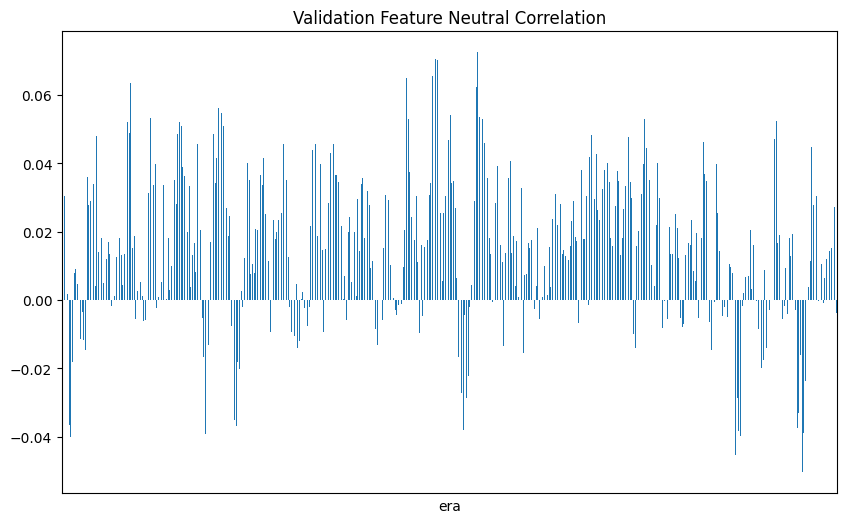

In [26]:
# Compute the per-era feature neutral correlation
# In this example, we neutralize the predictions against the "small" set of features that we used for training at a proportion of 1.0
# In practice, you may want to neutralize against a larger set of features and/or at a lower proportion
per_era_feature_neutral_correlation = validation_data.groupby("era").apply(lambda x: feature_neutral_corelation(x["prediction"], x["target"], x[feature_cols]))
per_era_feature_neutral_correlation.plot(kind="bar", title="Validation Feature Neutral Correlation", figsize=(10, 6), xticks=[]);

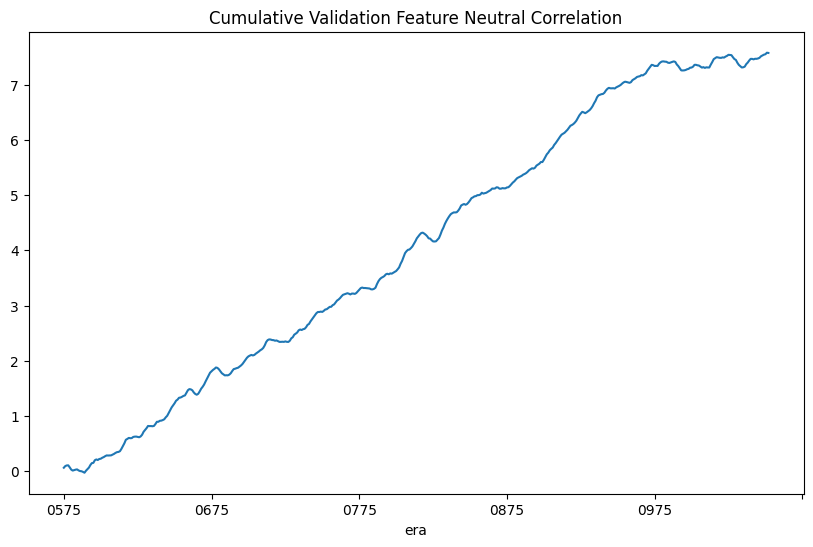

In [27]:
# Similar to above, we can also look at the cumulative feature neutral correlation over time
per_era_feature_neutral_correlation.cumsum().plot(title="Cumulative Validation Feature Neutral Correlation", figsize=(10, 6));

# 3. Submissions
Unlike a Kaggle competition where models are often evaluated based on their performance on a hold out test set, Numerai evaluates models based only on their <ins>live performance</ins> in the real stock market.

To compete in the tournament, your model must submit live predictions on live features released every day. Only the scores of these live predictions count towards your model's live performance.

Here is how you create a single live submission using the latest live features released today. 

In [28]:
# Download latest live features
napi.download_dataset("v4.1/live.parquet");

# Load live features
live_features = pd.read_parquet("v4.1/live.parquet", columns=feature_cols)

# Generate live predictions
live_predictions = model.predict(live_features[feature_cols])

# Format submission
submission = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
submission

2023-04-12 15:56:45,500 INFO numerapi.utils: starting download
v4.1/live.parquet: 4.47MB [00:00, 11.2MB/s]                            


,prediction
id,
n00010f8c21b177f,0.479566
n00152e9dee4b154,0.498867
n00326454def2191,0.501579
n0033495d1eaff3e,0.510769
n003a85c56d64b08,0.511369
...,...
nffcbc936d783655,0.499039
nffce34983cbd43b,0.465250
nffe00d7fad5fce0,0.499777


To automate your daily submissions, you can simply <ins>upload your model</ins> to Numerai. Once uploaded, Numerai will take care of running your model against the latest live features and generating live submissions every day.

Use the example code below to pickle your model into a file that can be uploaded to Numerai. 

In [29]:
# Define any function that takes live features and returns live predictions
def predict(live_features):
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict)
with open("model.pkl", "wb") as f:
    f.write(p)

In [30]:
# If running in Google Colab, download the model file
# The `google.colab` module should always be available when running in Google Colab 
try:
  from google.colab import files
  files.download('model.pkl')
except:
  pass

Now head back to [numer.ai/](numer.ai/) to upload your model! 